In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import mylibrary.nnlib as tnn

In [246]:
class NonLinearLayerClip(tnn.NonLinearLayer):
    def __init__(self, input_dim, output_dim, activation=None, weights=None, bias=None, optimizer=tnn.SGD()):
        super().__init__(input_dim, output_dim, activation, weights, bias, optimizer)
        
    def update(self):
        self.activation.update()
        
        gradients = self.weightsOpt.compute_gradient(self.del_weights)
        self.weights -= np.clip(gradients, -0.2, 00.2)
        gradients = self.biasOpt.compute_gradient(self.del_bias)
        self.bias -= np.clip(gradients, -0.2, 00.2)
        
    
class KLipschitzNet_Penalty(tnn.Layer):
    
    def __init__(self, layer_dims, optimizer, output_activation=tnn.Linear(), K=1):
        layer_list = []
        self.K = K
        for i in range(len(layer_dims)-1):
            if i+2 == len(layer_dims):
                actv = output_activation
            else:
                actv = tnn.Relu()
            layer = NonLinearLayerClip(layer_dims[i], layer_dims[i+1], activation=actv, optimizer=optimizer)
            layer_list.append(layer)

        self._net = tnn.AutoForm()
        self._net.layerList = layer_list
        
        self.preprocess()
        
    def preprocess(self):
        ## for all hidden layers
        for layer in self._net.layerList[:-1]:
            norm = np.linalg.norm(layer.weights,1,0, keepdims=True)
            layer.weights /= norm
        ## if the problem is regression, restirct the last layer for K-Lipschitz
        ## output layer
        layer = self._net.layerList[-1]
        norm = np.linalg.norm(layer.weights,1,0, keepdims=True)
        ## renormalize if the norm is greater than 1.
        re_norm = np.maximum(norm, 1)
        layer.weights /= re_norm
        return
    
    def get_dydx(self):
        dy_ = np.ones_like(self._net.layerList[-1].output)
        dx = self._net.backward(dy_)
        return dx
        
    def forward(self,inputs):
#         for layer in self._net.layerList[:-1]:
#             layer.weights = layer.weights/np.linalg.norm(layer.weights,1,0, keepdims=True)
        out = self._net.forward(inputs)
        return out
    
    def backward(self, del_output):
        dx = self._net.backward(del_output)
        return dx
    
    def update(self):  
        self._net.update()
#         self.preprocess()

### 1D Regression Dataset

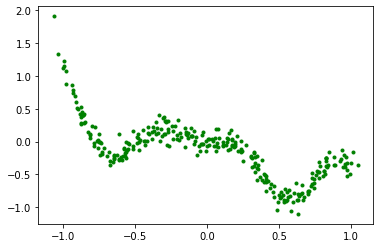

In [247]:
x = np.linspace(0,1,300)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
x = np.sort(x)

y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
y = -y#*0.5

x = x*2
x = x - x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.show()

## Test 3

Trying to fix the overshooting problem when |dydx|>K, in such case if the function wants to decrease slope itself, the algorithm 2 opposes.. tries to increase slope. 

-- decrease last layer weight magnitude if the lipschitz const is broken

In [265]:
optim = tnn.Adam(0.003)
net = KLipschitzNet_Penalty([1,10,1], optim)

In [266]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for epoch in range(100000):
#     yout = net.forward(xx)
    
#     dydx = net.get_dydx()
#     excess_slope = np.maximum(1, np.abs(dydx))
#     np.sign(dx_)*np.maximum(0, np.abs(dx_)-1)
#     yy_ = yy/excess_slope
#     dy = yout - yy_

#     dy = yout - yy
#     dydx = net.get_dydx()
#     ### These are dy multipliers
# #     dy_=np.exp(1/(np.clip(dydx, -1+1e-8, 1-1e-8)**4-1))*2.7183
#     dy_ = 1-np.abs(dydx)
# #     dy_ = np.maximum(1-np.abs(dydx), -0.5)
# #     dy_ = np.exp(-2*dydx**2)-0.13548
#     dy__ = dy*dy_
#     ### Direction correction for gradient
#     mask_correction = np.abs(dydx.reshape(-1))>1.
#     dy__[mask_correction] = np.abs(dy__[mask_correction]) # * np.sign(dydx[mask_correction])
#     ### dy is positive for all negative slope and viceversa
    
    if epoch%1==0:
        yout = net.forward(xx)
        dydx = net.get_dydx()
        slope_reduce = np.max(np.abs(dydx))
        if slope_reduce >1:
            net._net.layerList[-1].weights /= slope_reduce
        
    yout = net.forward(xx)
    dy = yout - yy
    
    dydx = net.get_dydx()
    dy_ = np.clip(1-np.abs(dydx), -0.5, 1)
    
    dx = net.backward(dy*dy_)
    net.update()
    
    if epoch%100 == 0:# or (epoch>1500 and epoch%10==0):
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(x, dydx.reshape(-1), color='c', marker='.', label='slope')  

        ax.scatter(x, y, marker='.', color='g', label='data')
        ax.plot(x, yout.reshape(-1), color='r', lw=3, label='output')
#         ax.scatter(x, (-dy__+yout).reshape(-1), color='y', marker='.', label='modified_data')


        ax.hlines([1,-1], xmin=x.min(), xmax=x.max())
        ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.158448617778538


100 Error =  0.087650091809913


200 Error =  0.08742481100898111


300 Error =  0.08176232238021072


400 Error =  0.07104143649711082


500 Error =  0.06390246877044015


600 Error =  0.06098587130755616


700 Error =  0.05630835622342396


800 Error =  0.052386740760271264


900 Error =  0.05139679891329182


1000 Error =  0.05061673371535672


1100 Error =  0.05053112460816458


1200 Error =  0.05038730239665368


1300 Error =  0.05012949189711823


1400 Error =  0.050250473999022584


1500 Error =  0.0500661952691757


1600 Error =  0.05009790970624323


1700 Error =  0.04985191667057057


1800 Error =  0.04986930552932932


1900 Error =  0.05005888647884522


2000 Error =  0.049953898720935086


2100 Error =  0.04990923627240247


2200 Error =  0.04978825938045334


2300 Error =  0.049707525060084454


2400 Error =  0.04994284704337331


2500 Error =  0.04978888264371263


2600 Error =  0.049833678920876735


2700 Error =  0.05037503892248418


2800

TclError: invalid command name "."

## Test 2
##### Using derrivaive to scale the input (Successful)

In [187]:
optim = tnn.Adam(0.01, 2/3)
net = KLipschitzNet_Penalty([1,10,1], optim)

In [188]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    
    dydx = net.get_dydx()
#     dydx = dydx + np.random.normal(0, 0.003, size=dydx.shape)

#     dy_=np.exp(1/(np.clip(dydx, -1+1e-8, 1-1e-8)**4-1))*2.7183
#     dy_ = 1-np.abs(dydx)
    dy_ = np.maximum(1-np.abs(dydx), -0.5)
#     dy_ = np.exp(-2*dydx**2)-0.13548
#     dy_ = dy_ + np.random.normal(0, 0.03, size=dydx.shape)

    dy__ = dy*dy_
    dx = net.backward(dy__)
    net.update()
    
    dymag = np.abs(dy).max()>1
    if epoch%100 == 0 or (dymag and epoch>300):
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(x, dydx.reshape(-1), color='c', marker='.', label='slope')  
        ax.scatter(x, dy_.reshape(-1), color='m', marker='.', label='slope_correction')
        
#         ax.scatter(x, dy.reshape(-1), color='y', marker='.', label='-grad')
        ax.scatter(x, (yout-dy__).reshape(-1), color='orange', marker='.', label='-final_grad')

        ax.scatter(x, y, marker='.', color='g', label='data')
        ax.plot(x, yout.reshape(-1), color='r', lw=3, label='output')

#         yout = net.forward(xx)
#         dy = yout - yy
#         print(np.abs(dy).max())
#         dx = net.backward(dy)
#         ax.scatter(x, dx.reshape(-1), color='y', marker='.', label='dx')


        ax.hlines([1,-1], xmin=x.min(), xmax=x.max())
        ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        if dymag: plt.pause(1)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.30283497533487186


100 Error =  0.08869165449720354


200 Error =  0.0761470209384628


300 Error =  0.05727269761214815


400 Error =  0.05042481714116115


500 Error =  0.04850494640403254


600 Error =  0.04782125887165319


700 Error =  0.047613201353792295


800 Error =  0.04796713352492882


900 Error =  0.04882345933931204


941 Error =  0.07266006857125694


942 Error =  0.08091442138499029


943 Error =  0.09169468272421377


944 Error =  0.10681964786777759


945 Error =  0.12625134374096744


946 Error =  0.1475261289763342


947 Error =  0.16204620182946788


948 Error =  0.16619063647727172


949 Error =  0.164025228335512


950 Error =  0.15571554784123878


951 Error =  0.13690892469784707


952 Error =  0.11663452766381174


953 Error =  0.10483958168790337


956 Error =  0.28492288625389584


957 Error =  0.6203181491949362


958 Error =  1.367950501304592


959 Error =  2.8690599941370163


960 Error =  5.622074746116842


961 Error =  10.24928490946911


TclError: can't invoke "update" command: application has been destroyed

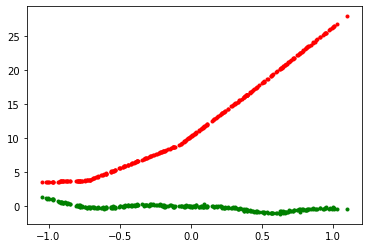

In [170]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

In [130]:
## decrease data slope to check if algorithm can adapt

In [135]:
# y_backup = copy.deepcopy(y)
y = copy.deepcopy(y_backup);yy = y.reshape(-1,1)

In [132]:
mask = x<-0.6
y[mask] = y[mask]*0.4
yy = y.reshape(-1,1)

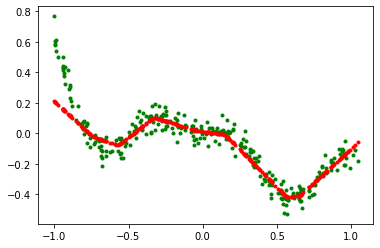

In [136]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')

## Test 1

In [145]:
optim = tnn.Adam(0.01)
net = KLipschitzNet_Penalty([1,5,1], optim)

In [146]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for epoch in range(100000):
    yout = net.forward(xx)
    dy = yout - yy
    
    dx = net.backward(dy)
    net.update()

    for i in range(4):
        yout = net.forward(xx)
        dx_ = net.get_dydx()
        dy_ = np.sign(dx_)*np.maximum(0, np.abs(dx_)-1)*0.5
        dx = net.backward(dy_)
        net.update()
    
#     dy__ = dy - dy_
#     dx = net.backward(dy__)
#     net.update()
    
    if epoch%100 == 0:
        
        error = (dy**2).mean()
        print(epoch, 'Error = ', error)
        ax.clear()
        
        ax.scatter(x, dx_.reshape(-1), color='c', marker='.', label='slope')  

#         ax.scatter(x, dy.reshape(-1), color='y', marker='.', label='-grad')
        ax.scatter(x, dy_.reshape(-1), color='m', marker='.', label='-slope_correction')
#         ax.scatter(x, dy__.reshape(-1), color='orange', marker='.', label='-final_grad')

        ax.scatter(x, y, marker='.', color='g', label='data')
        ax.plot(x, yout.reshape(-1), color='r', lw=3, label='output')
        ax.hlines([1,-1], xmin=x.min(), xmax=x.max())
        ax.legend()

        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            break

0 Error =  0.44876297001300675


100 Error =  0.0717291614703655


200 Error =  0.07482637715342319


300 Error =  0.08644585962689917


400 Error =  0.07832176966255548


500 Error =  0.07457082768145004


600 Error =  0.07342673861211743


700 Error =  0.07295891290482388


800 Error =  0.07287760033771941


900 Error =  0.07293823964940513


1000 Error =  0.07313613575722276


1100 Error =  0.07353498586977376


1200 Error =  0.07274696480491222


1300 Error =  0.07300564486058363


1400 Error =  0.07311540174119374


1500 Error =  0.0731395900305894


1600 Error =  0.08360673329544066


1700 Error =  0.07274320786902123


1800 Error =  0.07311489425944893


1900 Error =  0.07315639614153688


TclError: invalid command name "."

In [202]:
dx_ = net.get_dydx()

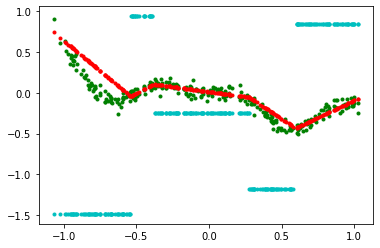

In [203]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, yout.reshape(-1), color='r', marker='.')
plt.scatter(x, dx_.reshape(-1), color='c', marker='.')